# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

## Options

In [ ]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             rotate=False, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=0)

Augmenting via y flips
Total augmentation multiplicity is 2


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


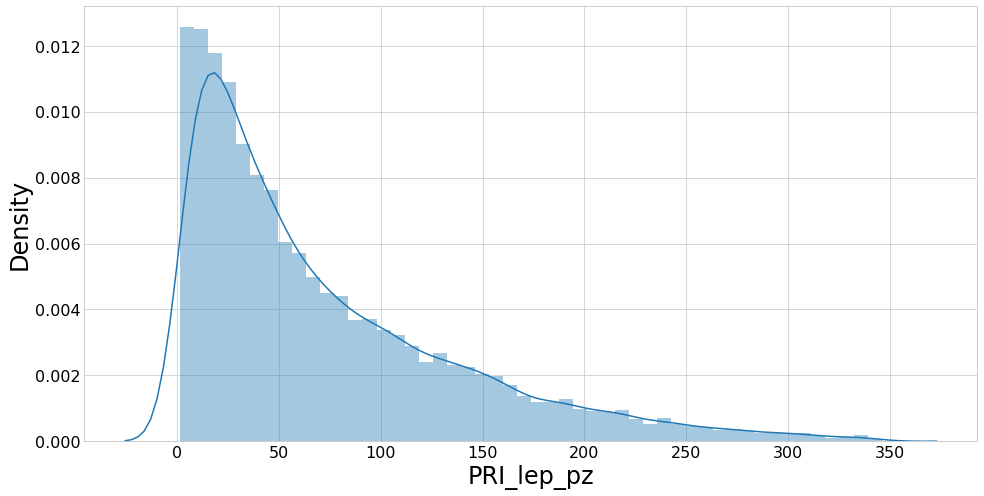

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


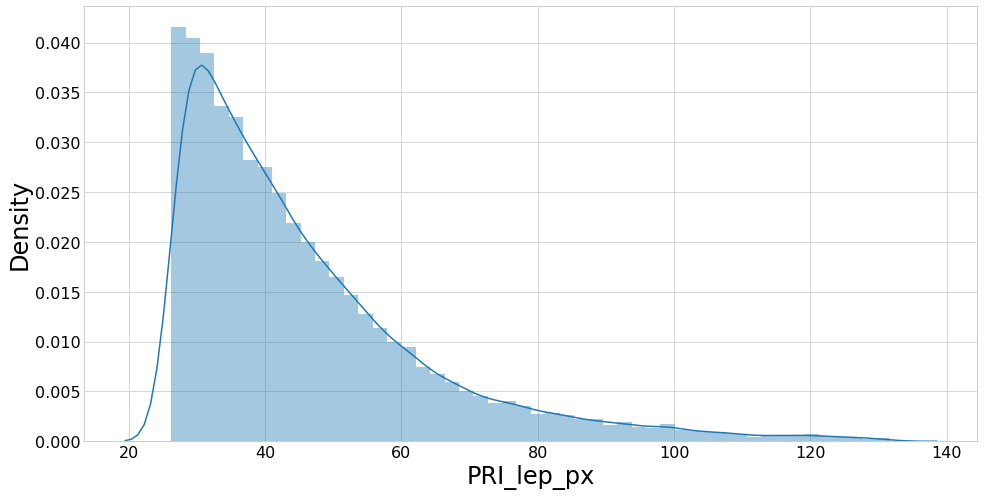

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


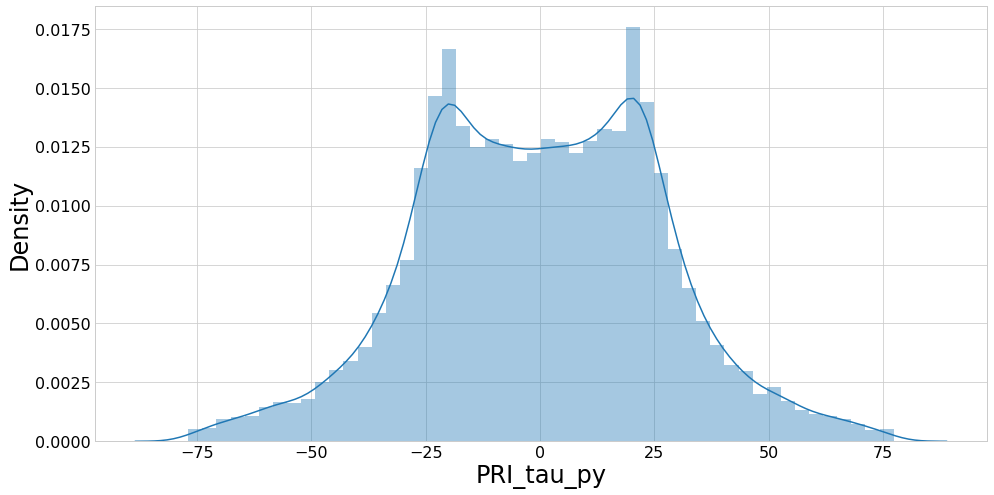

In [8]:
data = pd.DataFrame(input_pipe.inverse_transform(np.array(train_fy.source['fold_0/inputs'])), columns=train_feats)
plot_feat(data, 'PRI_lep_pz')
plot_feat(data, 'PRI_lep_px')
plot_feat(data, 'PRI_tau_py')

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 16.863s 


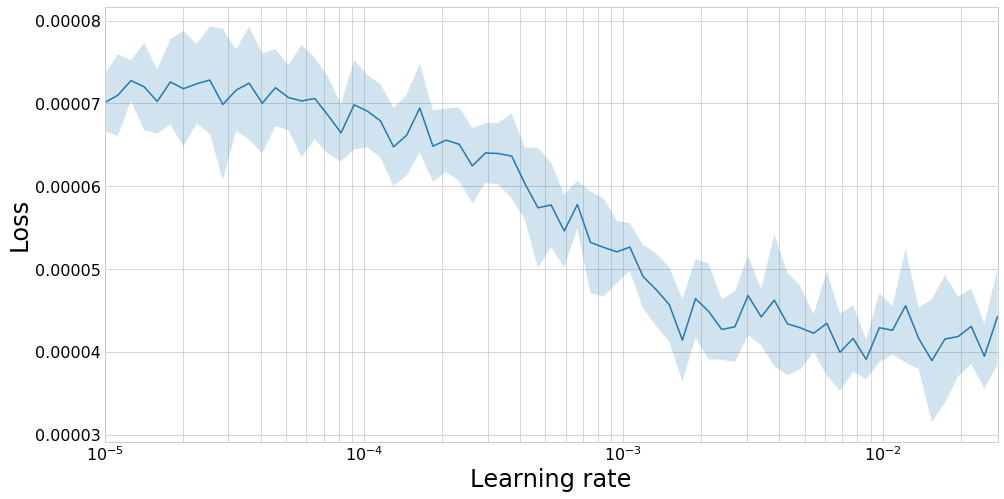

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [9]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105107). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7222422807221414e-05
2 New best found: 3.6012277951447245e-05
3 New best found: 3.4952206075877113e-05
4 New best found: 3.478496828397965e-05
5 New best found: 3.4375013458657246e-05
6 New best found: 3.371977452571523e-05
7 New best found: 3.355845838646956e-05
10 New best found: 3.3405171393332005e-05
12 New best found: 3.292042224507212e-05
13 New best found: 3.270425783665674e-05
14 New best found: 3.266113042376115e-05
15 New best found: 3.2578823298128354e-05
23 New best found: 3.25219988913859e-05
24 New best found: 3.242642373142825e-05
25 New best found: 3.2239788856928735e-05
28 New best found: 3.209367564939178e-05
29 New best found: 3.2071635718984675e-05
30 New best found: 3.2050528836367993e-05
31 New best found: 3.204899186808768e-05
54 New best found: 3.202203810875497e-05
55 New best found: 3.1935933136711704e-05
56 New best found: 3.192138011138955e-05
57 New best found: 3.1900139672256836e-05
CosineAnneal stalling after 127 epochs, entering redux

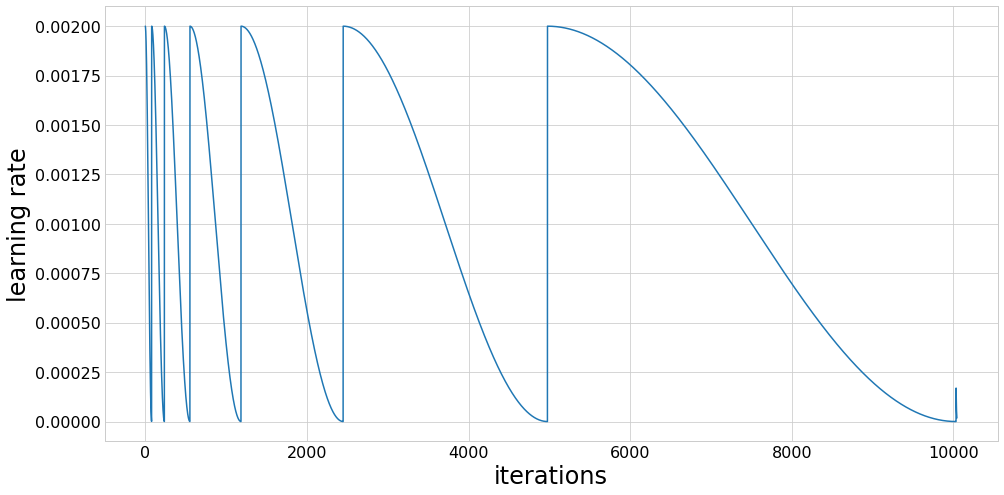

Fold took 116.742s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112342). Check your callbacks.
  % delta_t_median)


1 New best found: 3.693834376172163e-05
2 New best found: 3.5741677356418224e-05
3 New best found: 3.457069422438508e-05
5 New best found: 3.389563959353836e-05
6 New best found: 3.32229220381123e-05
7 New best found: 3.314812587195774e-05
10 New best found: 3.2741252322739455e-05
12 New best found: 3.2432006945600735e-05
13 New best found: 3.2381404752959495e-05
14 New best found: 3.228494980867253e-05
21 New best found: 3.2247973095218185e-05
24 New best found: 3.2057462885859425e-05
26 New best found: 3.189107372163562e-05
27 New best found: 3.189004880114226e-05
28 New best found: 3.1822613393887876e-05
29 New best found: 3.1759688025340435e-05
30 New best found: 3.17446884146193e-05
52 New best found: 3.164932665094966e-05
53 New best found: 3.164149107324192e-05
54 New best found: 3.160686965566129e-05
56 New best found: 3.1588317702698984e-05
57 New best found: 3.157379861659137e-05
61 New best found: 3.1573767417285126e-05
62 New best found: 3.1566092936554925e-05
63 New best f

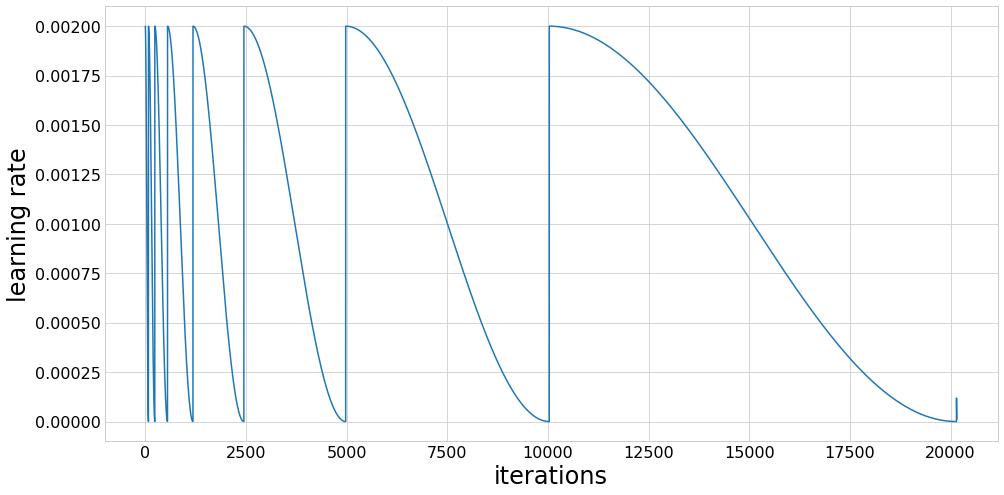

Fold took 230.000s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.230358). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115518). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7120696769852655e-05
2 New best found: 3.503355148131959e-05
3 New best found: 3.4528336631774436e-05
4 New best found: 3.441112852742663e-05
5 New best found: 3.3785813188296745e-05
6 New best found: 3.328915616293671e-05
7 New best found: 3.309272908663843e-05
9 New best found: 3.296217876631999e-05
10 New best found: 3.2862023642519486e-05
12 New best found: 3.281470661167987e-05
13 New best found: 3.2283675781218334e-05
14 New best found: 3.223776808154071e-05
15 New best found: 3.2207219080009964e-05
24 New best found: 3.20094488633913e-05
25 New best found: 3.1912624268443324e-05
26 New best found: 3.1828531103383285e-05
27 New best found: 3.178157075017225e-05
28 New best found: 3.171070098760538e-05
29 New best found: 3.1692444943473674e-05
54 New best found: 3.1554855666763616e-05
55 New best found: 3.151570838381303e-05
56 New best found: 3.149800622049952e-05
57 New best found: 3.149640651390655e-05
58 New best found: 3.145117047097301e-05
99 New best fou

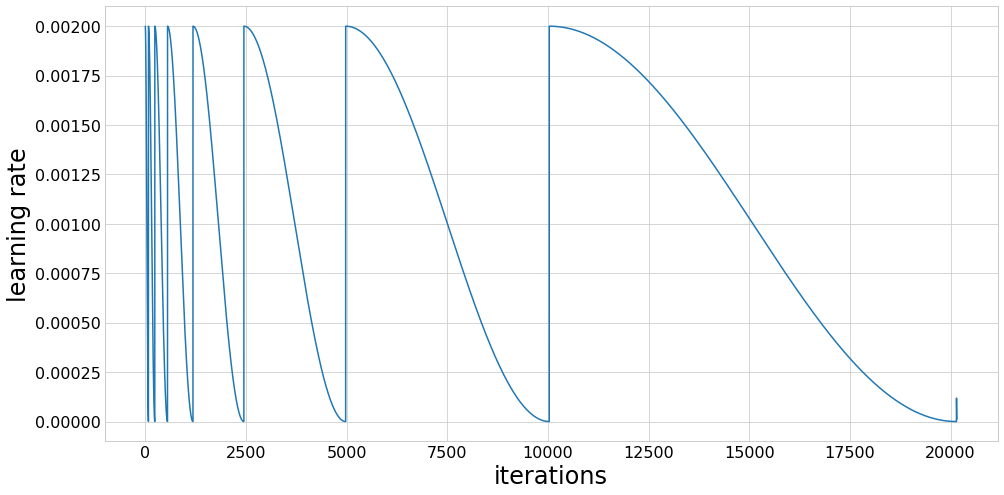

Fold took 237.448s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.277973). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139318). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8245055596629145e-05
2 New best found: 3.6010016568073616e-05
3 New best found: 3.539476422638112e-05
4 New best found: 3.47923749736837e-05
5 New best found: 3.412694121294935e-05
6 New best found: 3.39020912550704e-05
7 New best found: 3.362989746077351e-05
11 New best found: 3.3539847902385983e-05
12 New best found: 3.3234306998793446e-05
13 New best found: 3.307991785788633e-05
14 New best found: 3.295635326903137e-05
15 New best found: 3.2926684649208444e-05
24 New best found: 3.284849392896241e-05
25 New best found: 3.2740650704311046e-05
26 New best found: 3.266595895708152e-05
27 New best found: 3.2599304010554216e-05
29 New best found: 3.255510270742114e-05
30 New best found: 3.254440346607771e-05
51 New best found: 3.2513623622777034e-05
52 New best found: 3.237860299800616e-05
56 New best found: 3.237600369467267e-05
59 New best found: 3.23432127336e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=7.659675222511076e-05
133 New best f

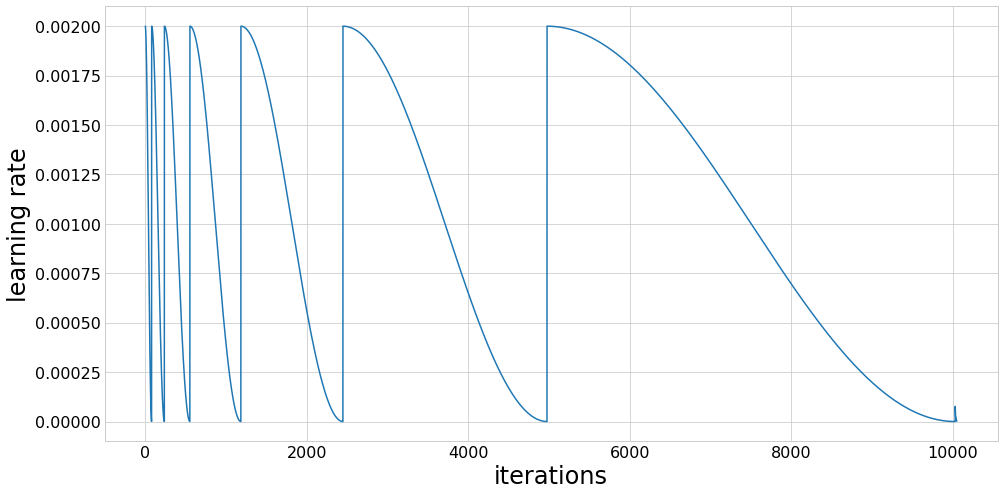

Fold took 138.301s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.311195). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155947). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8319721283914984e-05
2 New best found: 3.543087693833513e-05
3 New best found: 3.4919331617129504e-05
4 New best found: 3.461548700579442e-05
5 New best found: 3.413193403102923e-05
6 New best found: 3.362037774641067e-05
7 New best found: 3.342096952255815e-05
10 New best found: 3.314185286144493e-05
11 New best found: 3.2988719998684246e-05
13 New best found: 3.276106699922821e-05
14 New best found: 3.268326554534724e-05
15 New best found: 3.268241677142214e-05
21 New best found: 3.2649077981477604e-05
23 New best found: 3.244843890715856e-05
25 New best found: 3.224688655755017e-05
26 New best found: 3.216462774289539e-05
28 New best found: 3.211249333980959e-05
30 New best found: 3.209407431277214e-05
31 New best found: 3.2077944102638865e-05
48 New best found: 3.198124954942614e-05
51 New best found: 3.192537502181949e-05
52 New best found: 3.181599994713906e-05
58 New best found: 3.172413014108315e-05
60 New best found: 3.171895470004529e-05
61 New best found:

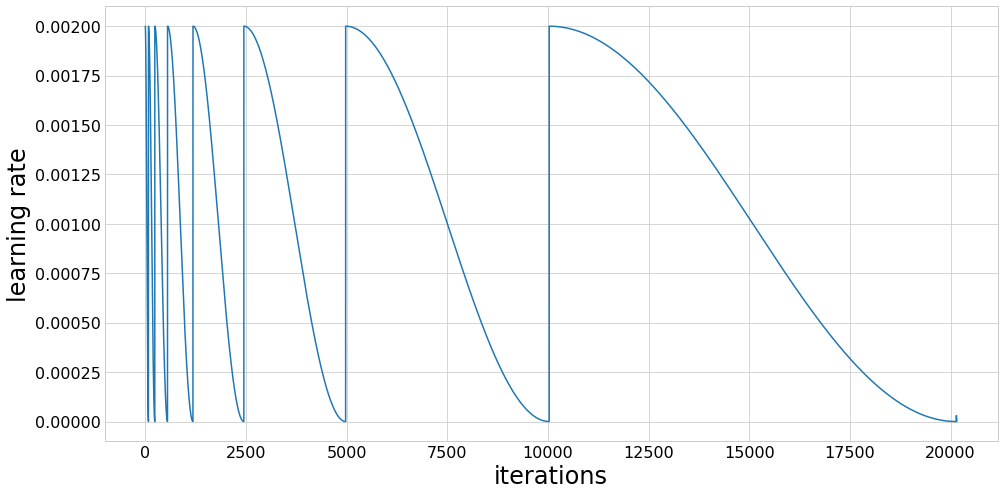

Fold took 254.186s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.329474). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165151). Check your callbacks.
  % delta_t_median)


1 New best found: 3.774848656484705e-05
2 New best found: 3.545819057020853e-05
3 New best found: 3.491137587496797e-05
4 New best found: 3.4220822997704e-05
5 New best found: 3.39922033917393e-05
6 New best found: 3.3542348588630195e-05
7 New best found: 3.3407479289414066e-05
10 New best found: 3.30971259257604e-05
11 New best found: 3.294927541425953e-05
13 New best found: 3.286403922126099e-05
14 New best found: 3.279319808182676e-05
15 New best found: 3.277565151356371e-05
22 New best found: 3.2615384868718484e-05
24 New best found: 3.2543986623736916e-05
26 New best found: 3.238883535928324e-05
28 New best found: 3.2234222309045484e-05
29 New best found: 3.21344392089287e-05
47 New best found: 3.205638949916642e-05
55 New best found: 3.203124964345239e-05
56 New best found: 3.1931023329318e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.00022777852649451198
Early stopping after 137 epochs
Score is: {'loss': 3.1931023329318e-05, 'wAUC': 0.06418536765292182

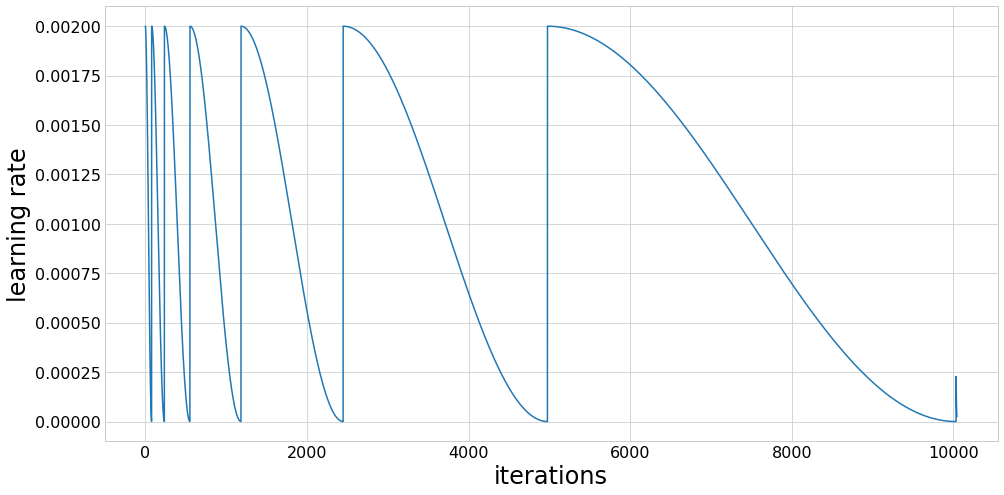

Fold took 134.649s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.328508). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164684). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9253703610645664e-05
2 New best found: 3.6023741366648603e-05
3 New best found: 3.530144368241081e-05
4 New best found: 3.461380928082626e-05
5 New best found: 3.444524307229947e-05
6 New best found: 3.366636596451112e-05
7 New best found: 3.357112836556532e-05
11 New best found: 3.346249893714575e-05
12 New best found: 3.299397687393227e-05
13 New best found: 3.278807287549075e-05
14 New best found: 3.276053891174641e-05
15 New best found: 3.2739716379676316e-05
21 New best found: 3.267678550053534e-05
23 New best found: 3.2620897266581465e-05
24 New best found: 3.258306022351391e-05
25 New best found: 3.238151426546482e-05
27 New best found: 3.237246771289711e-05
28 New best found: 3.230669581115305e-05
29 New best found: 3.2296722567662174e-05
30 New best found: 3.2255497379921004e-05
31 New best found: 3.2253852936644054e-05
50 New best found: 3.220175532143961e-05
51 New best found: 3.20965570872308e-05
52 New best found: 3.197783887943292e-05
56 New best found

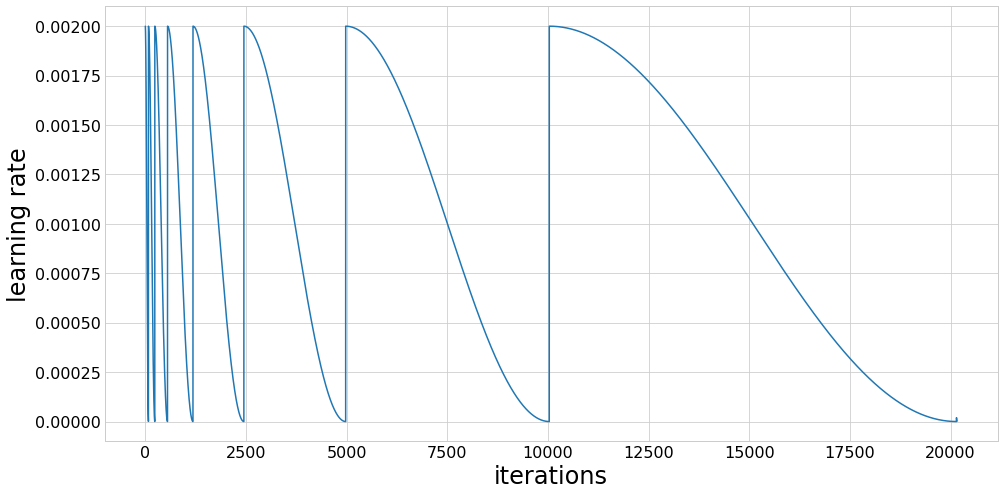

Fold took 261.260s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.350597). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175753). Check your callbacks.
  % delta_t_median)


1 New best found: 3.721236674755346e-05
2 New best found: 3.501511354697868e-05
3 New best found: 3.4337503121059856e-05
4 New best found: 3.415071846684441e-05
5 New best found: 3.3894234942272306e-05
6 New best found: 3.3196203474653886e-05
7 New best found: 3.308688164834166e-05
10 New best found: 3.289978809189051e-05
11 New best found: 3.266391926299548e-05
12 New best found: 3.24582503613783e-05
13 New best found: 3.22570503631141e-05
14 New best found: 3.21607523059356e-05
15 New best found: 3.214753782958724e-05
23 New best found: 3.2100583854480646e-05
24 New best found: 3.2037949700315946e-05
25 New best found: 3.198907493933803e-05
26 New best found: 3.198065340402536e-05
27 New best found: 3.1870694992539936e-05
28 New best found: 3.1800413015298543e-05
29 New best found: 3.169481205841294e-05
30 New best found: 3.167735170718515e-05
31 New best found: 3.1676540423359254e-05
49 New best found: 3.1623533394304106e-05
50 New best found: 3.156783439044375e-05
53 New best found

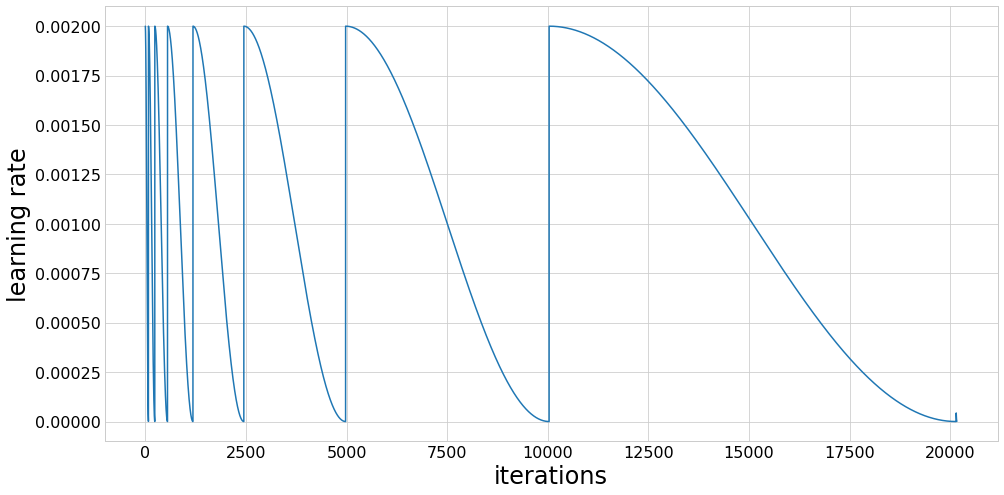

Fold took 272.873s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.371290). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186025). Check your callbacks.
  % delta_t_median)


1 New best found: 3.830130616603532e-05
2 New best found: 3.562892012260819e-05
3 New best found: 3.5053316916705455e-05
4 New best found: 3.472067598904218e-05
5 New best found: 3.399338922364485e-05
6 New best found: 3.363113169978434e-05
7 New best found: 3.359755428271227e-05
10 New best found: 3.3263520537182155e-05
11 New best found: 3.319115397267263e-05
12 New best found: 3.278966792018526e-05
13 New best found: 3.275272002376505e-05
14 New best found: 3.264836767578544e-05
15 New best found: 3.260954165220136e-05
22 New best found: 3.255343483838527e-05
24 New best found: 3.250250771081885e-05
25 New best found: 3.247837461844506e-05
26 New best found: 3.2207754296841423e-05
27 New best found: 3.2164340133833166e-05
28 New best found: 3.2113243156610755e-05
29 New best found: 3.210456001607905e-05
30 New best found: 3.208015241323754e-05
48 New best found: 3.19770973720347e-05
52 New best found: 3.195251647237229e-05
53 New best found: 3.1898900860135016e-05
54 New best found:

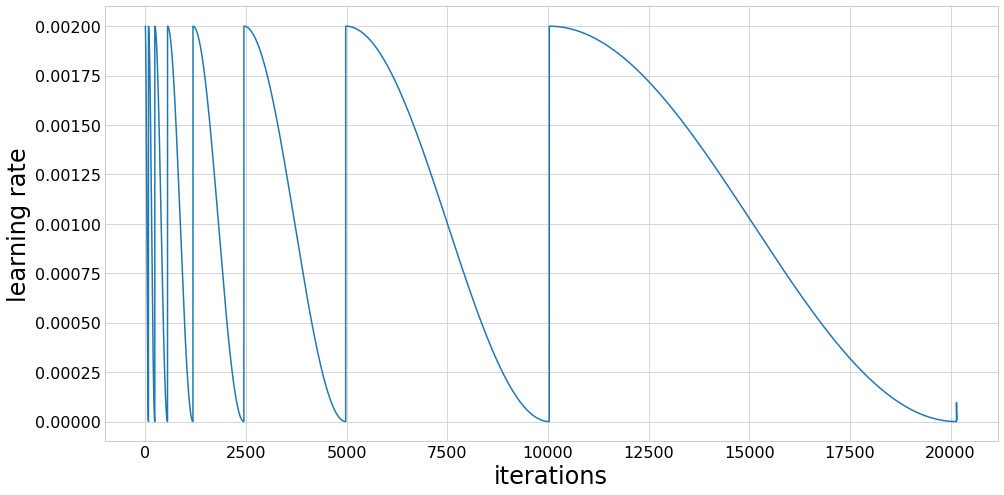

Fold took 274.686s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.429248). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215009). Check your callbacks.
  % delta_t_median)


1 New best found: 3.767363787324474e-05
2 New best found: 3.552897959579293e-05
3 New best found: 3.4944490030278985e-05
4 New best found: 3.4341184701229824e-05
5 New best found: 3.390994092363404e-05
6 New best found: 3.3502170368325295e-05
7 New best found: 3.341039026106134e-05
11 New best found: 3.3198207267336706e-05
12 New best found: 3.2963664048478886e-05
13 New best found: 3.2813098565729145e-05
14 New best found: 3.271148802416772e-05
15 New best found: 3.2634158778590075e-05
25 New best found: 3.250255627392309e-05
26 New best found: 3.236494995527172e-05
28 New best found: 3.2248415990427076e-05
49 New best found: 3.217734750011335e-05
53 New best found: 3.216553977911186e-05
54 New best found: 3.21564050004233e-05
55 New best found: 3.204840919263192e-05
58 New best found: 3.2001006662861696e-05
59 New best found: 3.197147860407848e-05
62 New best found: 3.197057684419693e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=4.937849712107852e-06
Early st

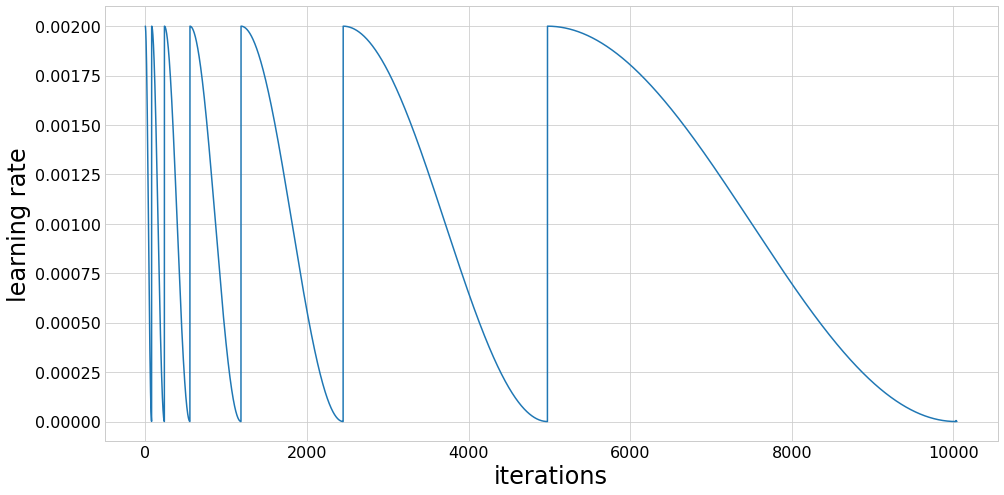

Fold took 146.941s


______________________________________
Training finished
Cross-validation took 2069.901s 


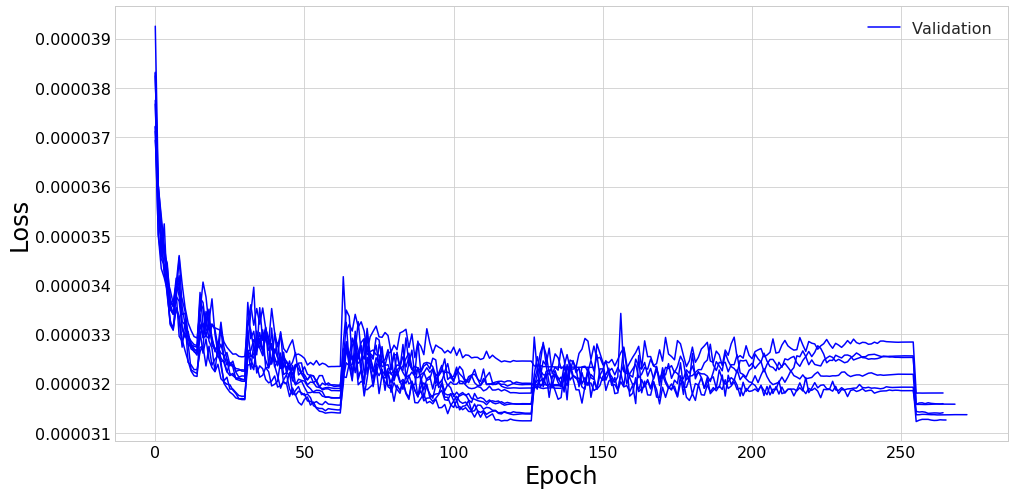

Mean loss = 3.17e-05 +- 1e-07
Mean wAUC = 0.063 +- 0.0004
Mean AUC = 0.0982 +- 0.0007
Mean AMS = 3.83 +- 0.05
Mean cut = 0.958 +- 0.006
______________________________________



<Figure size 432x288 with 0 Axes>

In [10]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

The impact of data augmentation is pretty clear. Comparing the training here to that of the the CRL Swish model without augmentation we can see that we effectively gain another LR cycles worth of training epochs before we start overfitting, which allows the networks to reach much lower looses (3.18e-5 c.f. 3.23e-5) and a higher AMSs (3.98 c.f. 3.71)

## Construct ensemble

In [11]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [12]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 2 with loss = 3.123218968103174e-05
Model 1 is 7 with loss = 3.1366427744796964e-05
Model 2 is 1 with loss = 3.138595660275314e-05
Model 3 is 8 with loss = 3.1564017109283165e-05
Model 4 is 4 with loss = 3.157719126029406e-05
Model 5 is 6 with loss = 3.180648083168822e-05
Model 6 is 0 with loss = 3.1900139672256836e-05
Model 7 is 5 with loss = 3.1931023329318e-05
Model 8 is 9 with loss = 3.197057684419693e-05
Model 9 is 3 with loss = 3.232976637760633e-05


## Response on validation data without TTA

In [13]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [14]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0017608740210533142s per sample

Predicting fold 2 out of 10
Prediction took 0.00039619055278599264s per sample

Predicting fold 3 out of 10
Prediction took 0.00040367832481861117s per sample

Predicting fold 4 out of 10
Prediction took 0.0004026252798736095s per sample

Predicting fold 5 out of 10
Prediction took 0.0003953406307846308s per sample

Predicting fold 6 out of 10
Prediction took 0.00039829995445907115s per sample

Predicting fold 7 out of 10
Prediction took 0.00040724310390651225s per sample

Predicting fold 8 out of 10
Prediction took 0.00040016286112368106s per sample

Predicting fold 9 out of 10
Prediction took 0.0003950366102159023s per sample

Predicting fold 10 out of 10
Prediction took 0.00039616176411509516s per sample



In [15]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9039120332693915, weighted 0.9360604594166104


In [16]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.999747665253905, 0.9658155)

In [17]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.964+-0.008
Exact mean cut 0.9637830952415243, corresponds to calc_ams of 3.9548787121564013
CPU times: user 2.53 s, sys: 10.4 s, total: 12.9 s
Wall time: 4min 31s


(4.0, 0.964)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

## Response on validation data with TTA

In [18]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                             rotate=False, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=0)

Augmenting via y flips
Total augmentation multiplicity is 2


In [19]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0008151369199156761s per sample

Predicting fold 2 out of 10
Prediction took 0.0008154710952192545s per sample

Predicting fold 3 out of 10
Prediction took 0.0008096545126289129s per sample

Predicting fold 4 out of 10
Prediction took 0.0008194883480668068s per sample

Predicting fold 5 out of 10
Prediction took 0.0008142452225089074s per sample

Predicting fold 6 out of 10
Prediction took 0.0008095134548842907s per sample

Predicting fold 7 out of 10
Prediction took 0.0008110566176474094s per sample

Predicting fold 8 out of 10
Prediction took 0.0008172810673713684s per sample

Predicting fold 9 out of 10
Prediction took 0.000809984752163291s per sample

Predicting fold 10 out of 10
Prediction took 0.000820887878164649s per sample



In [20]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9039753803882244, weighted 0.9360900290186888


In [21]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(4.010937206990357, 0.9657905)

In [22]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.1+-0.2, at mean cut of 0.963+-0.008
Exact mean cut 0.9632482554297894, corresponds to calc_ams of 3.9272991329339857
CPU times: user 2.58 s, sys: 10.2 s, total: 12.8 s
Wall time: 4min 28s


(4.1, 0.963)

Adding test-time augmentation provides further benefits: overall AMS 3.90->3.97, AMS corresponding to mean cut 3.89->3.91.

# Test scoring - Without TTA

In [23]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [24]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0004046396689997478s per sample

Predicting fold 2 out of 10
Prediction took 0.00040367664383216337s per sample

Predicting fold 3 out of 10
Prediction took 0.0003988779935647141s per sample

Predicting fold 4 out of 10
Prediction took 0.00040225246623158456s per sample

Predicting fold 5 out of 10
Prediction took 0.00040106305270032447s per sample

Predicting fold 6 out of 10
Prediction took 0.00040208108916201375s per sample

Predicting fold 7 out of 10
Prediction took 0.00040199877321720124s per sample

Predicting fold 8 out of 10
Prediction took 0.0003988572912460024s per sample

Predicting fold 9 out of 10
Prediction took 0.00040958516245538537s per sample

Predicting fold 10 out of 10
Prediction took 0.0004045397124845873s per sample

CPU times: user 4min, sys: 6.23 s, total: 4min 6s
Wall time: 3min 41s


In [25]:
score_test_data(test_fy.source, 0.9637830952415243)

Public:Private AMS: 3.6274848790196317 : 3.7115229236555516


(3.6274848790196317, 3.7115229236555516)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Test scoring - With TTA

In [26]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                             rotate=False, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=0)

Augmenting via y flips
Total augmentation multiplicity is 2


In [27]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0008064975128932433s per sample

Predicting fold 2 out of 10
Prediction took 0.0008052932564169169s per sample

Predicting fold 3 out of 10
Prediction took 0.0008076995851302688s per sample

Predicting fold 4 out of 10
Prediction took 0.0008041213103654709s per sample

Predicting fold 5 out of 10
Prediction took 0.0008032613270662047s per sample

Predicting fold 6 out of 10
Prediction took 0.0007981079639020291s per sample

Predicting fold 7 out of 10
Prediction took 0.0008044388883493163s per sample

Predicting fold 8 out of 10
Prediction took 0.0008053462740711191s per sample

Predicting fold 9 out of 10
Prediction took 0.0008057153410193595s per sample

Predicting fold 10 out of 10
Prediction took 0.0007992798146537759s per sample

CPU times: user 8min 2s, sys: 12.1 s, total: 8min 14s
Wall time: 7min 22s


In [28]:
score_test_data(test_fy.source, 0.9632482554297894)

Public:Private AMS: 3.6358572685284005 : 3.715941763396622


(3.6358572685284005, 3.715941763396622)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)